# Recommender System - Books
This notebook contains code to build several common recommender systems to fit different business scenarios, e.g., cold start for both item and user, recommendation based on item metadata only, and sparse interaction table.


*The book crossing dataset is used and can be downloaded [here](http://www2.informatik.uni-freiburg.de/~cziegler/BX/).*

<a id = 'toc'></a>
**Table of Contents**
1. [**EDA**](#eda)
    1. [**items**](#eda)
    2. [**users**](#u)
    3. [**interactions**](#i)
1. [**Random Recommender**](#rand): easy to implement, appropriate for **Cold start**, i.e., no user yet, only item information, but not informational
2. [**Most Popular Recommender**](#pop): easy to implement, only need some user interaction, but every user gets the same recommendation, more informational than random, but doesn't learn from individual items or users. 
3. [**Content Based Recommender**](#cb): uses mostly item data, also robust for **Cold start**, i.e., no user yet or with limited user interaction data, but costly to train, and similarity is based on intrinsic features not user preferences
4. [**Collaborative Filtering Recommender**](#cf): uses interaction data only, learn user preference of items through interaction, faster to implement, more informational
    1. [**Memory based**](#cf-knn): more interaction, the better, expensive to train as it uses the entire data, less stable with sparse matrix
        1. **User-based filtering**: "How do similar users rate it?"; predict rating by combining similar users' ratings of the same item
        2. **Item-based filtering**: "How are similar items rated?"; predict rating by combining similar item's ratings from the same user
    2. [**Model based**](#cf-mf):
        1. **Matrix Factorization**: Find users' preference on latent factors that are endorsed by items.
7. [**Reference**](#ref)

Next up: 
- **Hybrid with lightFM**: matrix factorization mixed with content based methods
- **Deep Learning with fastai & Pytorch**: collaborative filteirng with deep neural net


In [1]:
# import libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')

import ipyplot
import random
import string

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

from surprise import Dataset, Reader, KNNWithMeans, SVD
from surprise.accuracy import rmse, mae
from surprise.model_selection import GridSearchCV

import pickle

<a id = 'eda'></a>
## 1. EDA
### 1.A Item Data EDA - books

In [2]:
# import books data
bdf = pd.read_csv('data/BX-Books.csv', sep='(?<=");(?=")', encoding='latin-1', engine = 'python')
bdf.columns = ['isbn', 'title', 'author', 'year', 'publisher', 'imgurls', 'imgurlm', 'imgurll']
bdf = bdf.applymap(lambda x: x.strip('"'))
print (bdf.shape)
bdf.iloc[::100000]

(271379, 8)


,isbn,title,author,year,publisher,imgurls,imgurlm,imgurll
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
100000,0373707495,Memories Of You (Bestselling Author Flash) (Ha...,Margot Dalton,1997,Harlequin,http://images.amazon.com/images/P/0373707495.0...,http://images.amazon.com/images/P/0373707495.0...,http://images.amazon.com/images/P/0373707495.0...
200000,0442203829,Cell biology,Charlotte J Avers,1976,Van Nostrand,http://images.amazon.com/images/P/0442203829.0...,http://images.amazon.com/images/P/0442203829.0...,http://images.amazon.com/images/P/0442203829.0...


In [3]:
# book EDA
bdf.describe()

,isbn,title,author,year,publisher,imgurls,imgurlm,imgurll
count,271379,271379,271379,271379,271379,271379,271379,271379
unique,271379,242154,102028,116,16807,271063,271063,271063
top,0590437712,Selected Poems,Agatha Christie,2002,Harlequin,http://images.amazon.com/images/P/074321689X.0...,http://images.amazon.com/images/P/156865765X.0...,http://images.amazon.com/images/P/015694877X.0...
freq,1,27,632,17628,7536,2,2,2


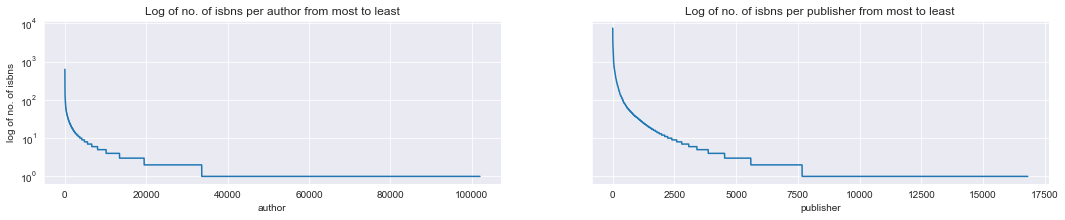

In [4]:
fig, ax = plt.subplots(1, 2, figsize = (18, 3), sharey=True)

bdf.groupby('author').isbn.count().sort_values(ascending=False).reset_index(drop=True).plot(logy=True, ax=ax[0])
bdf.groupby('publisher').isbn.count().sort_values(ascending=False).reset_index(drop=True).plot(logy=True, ax=ax[1])

ax[0].set(ylabel = 'log of no. of isbns', xlabel = 'author', title='Log of no. of isbns per author from most to least')
ax[1].set(xlabel = 'publisher', title = 'Log of no. of isbns per publisher from most to least')

plt.show()

**Books Metadata Observation:**
1. There are over 270,000 unique isbns under ~240,000 book names written by ~100,000 authors and published by ~16,000 publishers. 
2. Less than 30% of authors have more than one ISBNs under their name, but a coulple hundred of them have more than 10 ISBNs. Agatha Christie is the most prolific author, having 632 ISBNs under her name. This includes translations of the same book into different languages for this popular crime novelist.
3. Same observation holds for publisher. More than half of the publsihers have ever release one ISBN. 2,500 of them published more than 10 books, and a small handful of them publishsed thousands of books. Harlequin is the champion in publishers, having over 7000 ISBNs under its name.

[back to top](#toc)

<a id = 'u'></a>
### 1.B. User Data EDA

In [5]:
# user metadata
udf = pd.read_csv('data/BX-Users.csv', sep=';', encoding='latin-1')
udf.columns = ['uid', 'location', 'age']
print(udf.shape)
udf.iloc[::100000, :]

(278858, 3)


,uid,location,age
0,1,"nyc, new york, usa",NaN
100000,100001,"grimstad, aust-agder, norway",NaN
200000,200001,"des moines, iowa, usa",49.0


In [6]:
udf.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
uid,278858.0,139429.500000,80499.515020,1.0,69715.25,139429.5,209143.75,278858.0
age,168096.0,34.751434,14.428097,0.0,24.00,32.0,44.00,244.0


In [7]:
udf.location.describe()

count                              278858
unique                              57339
top       london, england, united kingdom
freq                                 2506
Name: location, dtype: object

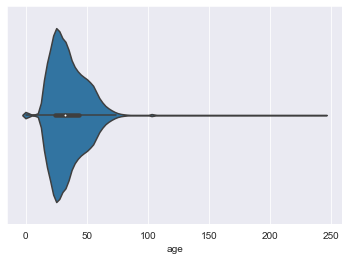

In [8]:
sns.violinplot(udf.age)
plt.show()

In [9]:
udf.age.quantile(np.arange(0,1,0.1))

0.0     0.0
0.1    19.0
0.2    23.0
0.3    26.0
0.4    29.0
0.5    32.0
0.6    36.0
0.7    41.0
0.8    47.0
0.9    55.0
Name: age, dtype: float64

**User data observation**:
1. There are over 270,000 users uniquely identified by uid. 
2. 10% under 19, **40% in their 20s, another 20% in their 30s**, and 30% over 40.
2. They are from over 57,000 different cities around the work, and **london** being the most popular location.

[back to top](#toc)

<a id = 'i'></a>
### 1.C. Interaction Data EDA

In [25]:
# interaction data
idf = pd.read_csv('data/BX-Book-Ratings.csv', sep = ';', encoding='latin-1')
idf.columns = ['uid', 'isbn', 'rating']
print(idf.shape)
idf.iloc[::400000,:]

(1149780, 3)


,uid,isbn,rating
0,276725,034545104X,0
400000,96096,7119029770,10
800000,194229,0553265547,9


In [11]:
idf.loc[:,'uid'] = idf.uid.astype(str)
idf.describe(include = 'object').transpose()

,count,unique,top,freq
uid,1149780,105283,11676,13602
isbn,1149780,340556,0971880107,2502


1. There are **105,000 unique users who rated, which is around 40% of all users in the database**.
2. Over **340,000 isbns** were rated, which is more than we have record/inventory for, therefore, let's **drop ratings for this first**.
3. Let's also examine to see whether all the users who rated exist in our database.

In [26]:
print('Old ratings table shape: ', idf.shape)
idf = idf.loc[idf.isbn.isin(bdf.isbn), :]
print ('New ratings table shape: ', idf.shape)

Old ratings table shape:  (1149780, 3)
New ratings table shape:  (1031175, 3)


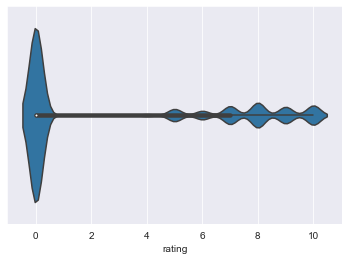

In [13]:
# ratings destribution
sns.violinplot(x = 'rating', data = idf); plt.show()

In [14]:
# rating quantile
idf.rating.quantile(np.arange(0,1,0.1))

0.0    0.0
0.1    0.0
0.2    0.0
0.3    0.0
0.4    0.0
0.5    0.0
0.6    0.0
0.7    6.0
0.8    8.0
0.9    9.0
Name: rating, dtype: float64

In [15]:
print ('The interaction table now contains {} ratings from {} users for {} books.'.format( idf.shape[0],
                                                                                          idf.uid.nunique(), 
                                                                                          idf.isbn.nunique()))

The interaction table now contains 1031175 ratings from 92107 users for 270170 books.


In [16]:
# ratings sparsity
idf.shape[0] / (idf.uid.nunique() * idf.isbn.nunique()) * 100

0.004143836537142288

**Ratings data EDA**:
1. There is a total of 1,031,175 ratings given by roughly 92,000 users on 270,000 books. 
2. Only **0.004%** of possible user-item pair is populated, making it **extremely sparse**. In order for recommndation to be more stable and to save computing power, we will **filter out less interacted users and books** in the next step.
3. For the ratings we do have, it is on a scale of 0 to 10, with more than **60% ratings at 0**, which, according to the data course, is implicit feedback. Judging by the scale of other ratings, it might not be a good indicator of the books' real ratings, but we will leave them there for now since we cannot justify our suspition.

**Next steps**:
1. Examine and create filsters for users and books.
2. Check whether each user rated the same item only once, if not, keep the higher one.

In [17]:
u_rct = idf.groupby('uid').isbn.count().sort_values(ascending=False) # user ratings count sorted 
b_rct = idf.groupby('isbn').uid.count().sort_values(ascending=False) # book ratings count sorted

In [18]:
# user rating quantiles
u_rct.quantile(np.arange(1,0.6, -0.1))

1.0    11144.0
0.9       13.0
0.8        5.0
0.7        3.0
Name: isbn, dtype: float64

In [19]:
# item rating quantiles
b_rct.quantile(np.arange(1, 0.6, -0.1))

1.0    2502.0
0.9       7.0
0.8       3.0
0.7       2.0
Name: uid, dtype: float64

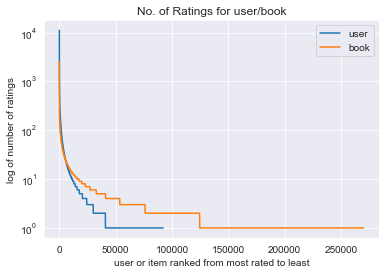

In [20]:
# visualize log rating counts
u_rct.reset_index(drop=True).plot(logy=True, label = 'user')
b_rct.reset_index(drop=True).plot(logy=True, label = 'book')
plt.title('No. of Ratings for user/book')
plt.ylabel('log of number of ratings')
plt.xlabel('user or item ranked from most rated to least')
plt.legend(loc = 1)
plt.show()

Here we observe the **long tail** property of rating tables in real world: 
1. Half of the users and items only have one rating associated to them
2. About **10%** of the users and items have more than 10 ratings;
3. The most active user rated over 10,000 items, and the most popular item has over 200 ratings. This is stark contrast between user behaviors.

**Sparse matrix affects collaborative filtering** models. Having lots of user item pairs means calculation volume for similarity measures. Also, having sparse matrix makes it difficult to calculate reliable/stable similarities, making KNN result unstable.

Therefore, we will **filter** books and users with more than 60 ratings. Obviousely, this choice is arbitrary, and the higher the threshold, the less users and book we can recommend for. But, we will **sacrifice** quantity for qualify right now. And for the less rated users and books, we can resort to other recommenders for recommendation, such as most popular and content based.

In [21]:
# create filter
u_thres = 60 # min user rating count
b_thres = 60 # min book rating count

u_filter = u_rct[u_rct > u_thres].index # user filter
b_filter = b_rct[b_rct > b_thres].index # book filter

In [22]:
print (len(u_filter), len(b_filter))

2567 1615


In [27]:
orig_idf = idf.copy()
print('Old rating dataframe shape: ', orig_idf.shape)
idf = idf.loc[(idf.uid.isin(u_filter)) & (idf.isbn.isin(b_filter))]
print('New rating dataframe shape: ', idf.shape)

Old rating dataframe shape:  (1031175, 3)
New rating dataframe shape:  (115206, 3)


In [24]:
idf.shape[0] /(len(u_filter) * len(b_filter))

0.02778924211925354

All right, **the interaction table we will be working with is now from 2500 users' 115,000 ratings on 1,600 books**. The matrix is **3% filled**, still quite sparse. However, this is **1000 times denser** than before, so, let's make some recommendations!

[back to top](#toc)

<a id = 'rand'></a>
## 2. Simple Recomendation - Random

When a service is brand new, all we have is item metadata, no user or user interaction yet. At this stage, there are two things we can do:

1. Recommend randomly - obviousely, this is not informed, the recommendation is a hit of miss, but you gotta start somewhere.
2. Recommend the most popular items - try to get some information about the items from existing services.

In [28]:
def get_n_items(ilist, idf = bdf, iid_col = 'isbn', n = 6):    
    '''return n itmes based on a list of item ids'''
        
    # lookup item meta data
    return_idf = idf.loc[idf[iid_col].isin(ilist)]
    
    # collect recommended item info
    images = return_idf.imgurlm.tolist()
    labels = (return_idf.title + ' by ' + return_idf.author).tolist()

    # retrieve and display recommendation
    ipyplot.plot_images(images, labels, max_images=20, img_width=130)
    
    return

In [29]:
def rec_rand_n(n = 6):
    '''Recommend random books'''
    
    # generate n random index for rec
    rec_list = random.sample(bdf.isbn.tolist(), n)
    
    # return recommendations
    get_n_items(rec_list)
    
    return

In [35]:
np.random.seed(3)
rec_rand_n()

Well, some*obscure* book choices... but hey, we are brand new here, at least, we have something to display.

But, surely, we can do better!

Let's borrow some publicly available information, say, scrape amazon and get the most popular books.
Now we can improve our recommendation with the most popular books!

[back to top](#toc)

<a id= 'pop'></a>
## 3. Recommend - Most Popular - **"Best Sellers"**

In [36]:
def rec_pop_n(n=6):
    '''Recommend the most popular (rated) books'''
    
    # get most popular n books' isbns
    rec_list = b_rct.iloc[:n].index
    
    # get rec info
    get_n_items(rec_list)
    
    return

In [37]:
rec_pop_n()

All right! Better than random as the **probability** of a new user liking a popular book is certainly **higher** than a **random** one. Ater all, that's why they are popular in the first place!

But, we have not even used anything we know about the books or the users! Surely, we can make more informed decisions once users use our recommender and we gradually learn more about their preferences .

**When a user starts to browse our collection of books, we can start to improve our recommendation based on their browse history**. Let's try content based filtering!

[back to top](#toc)

<a id = 'cb'></a>
## 4. Content Based Filtering - "You may also like..."

The name says it, content based filtering means recommendation based on content. Content here means metadata. For books, it could mean summary, for movies, it could mean plots, anything that tells us what the item is about. The idea is that based one user's browing history, we would recommend items similar to what they showed interest. 

Since the similarity between items is calcuated based on their metadata features. Generally speaking, we want to have **many informative features in order for content based filtering to work well**. In our scenario, however, the information we have on books is quite **limited**. This inevitably limits our recommender's performance compared to if we had features such as the book's summary, keywords, genre, etc. 

But, you gotta work with what you have. Plus, **book titles** could be quite informational, so, let's give it a try.

Since we have more than 270,000 books, it is quite costly to calculate the similarity measure. For demonstration purpose, we will subsample the most popular 10000 books.

In [38]:
pop_10000_isbn = b_rct[:10000].index
small_bdf = bdf.loc[bdf.isbn.isin(pop_10000_isbn)].copy()

In [39]:
# nlp preprocessing for three metadata features of books
small_bdf.loc[:, 'author'] = small_bdf.author.apply(lambda x: "".join(x.split()).translate(str.maketrans('', '', string.punctuation)))
small_bdf.loc[:, 'publisher'] = small_bdf.publisher.apply(lambda x: ''.join(x.split()).translate(str.maketrans('','',string.punctuation)))
small_bdf.loc[:, 'infoStr'] = small_bdf[['title', 'author', 'publisher']].agg(' '.join, axis=1)

In [40]:
# bag of words
tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df = 3, stop_words='english')
wc = tf.fit_transform(small_bdf.infoStr)
wc.shape

(10000, 6836)

In [32]:
# calculate similarity between books
cos_sim = linear_kernel(wc, wc)
cos_sim.shape

(10000, 10000)

In [33]:
sim_df = pd.DataFrame(cos_sim, index = small_bdf.isbn, columns=small_bdf.isbn)
sim_df.head()

isbn,0399135782,0440234743,0452264464,0609804618,1841721522,0971880107,0345402871,0345417623,0375759778,0375406328,...,0380810298,0345295250,0525945652,0373225156,0671743902,050552421X,0449002551,0679740244,3423128801,3407785682
isbn,,,,,,,,,,,,,,,,,,,,,
0399135782,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0
0440234743,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0
0452264464,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0
0609804618,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1575,0.0
1841721522,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0


In [34]:
# how many books have more than 20 books that have similarity measures with them
sum((1-((sim_df) == 0).sum()/sim_df.shape[0] )> 0.002)

9682

In [35]:
def cb_rec(title, n = 6):    
    '''Recommend books based on metadata similarity measures '''
       
    # get isbn corresponding to title
    isbn = bdf[bdf.title == title].isbn.tolist()[0]
    
    # get isbn thats most similar 
    rec_list = sim_df.loc[isbn, :].sort_values(ascending = False)[1:1+n].index
    
    # get other info of most similar books
    get_n_items(rec_list)
    
    return

In [56]:
np.random.seed(514) # random seed for reproducibility
title = small_bdf.iloc[np.random.randint(sim_df.shape[0])]['title'] # random title
print ('Because you read: ', title)
cb_rec(title) # make recommendations

Because you read:  LAKE NEWS : A Novel


As expected, content based recommender keeps you in your comfort zone. Look at the recommenation for the random title generated. They are all from the same author, not to mention the same title with a different ISBN! This tells us two things:
1. Our content based recommender works, with title, author and publisher only, this is not bad!
2. Top recommendations will be really similar to each other.

**Many sources argue that one of content based recommender's weakness is that it only recommends item within the same genre. But I think that it is a problem that is easy to overcome. Instead of recommending the most similar items, we could mix in items that are neutral or not similar to the seed item on purpose. We can easily implement it by picking itmes that are in the middle or towards the end of the sorted similar items list.**

It is worth noting that out of the 9,600 books selected to make this recommender, there are 300 books that have less than 20 similarity scores. This shows that with **very limited information about a large amount of book**, it is highly likely that **some books will have features that are one of a kind, thus yielding 0 similarity scores with other books. If so, this book will not likely be recommended by the algorithm. And recommendation based on such books will be random.**

And, it will indeed be **expensive to compute similarity scores of over 270,000 books based on hundreds of thousands of features**! Not to mention, so far, we are still defining user preference indirectly via item features. This is a good start when we don't have many users to cross reference. But, since we do have an interaction table, let's **incorporate users' preference directly from their interactions with the items!**

[back to top](#toc)

<a id = 'cf'></a>
## 5. Collaborative Filtering
Collaborative filtering(CF) puts emphasis on **"Collaborative"**. Users' tastes are more objectively reflected in their interaction with the items. Therefore, to guess what we may like, we can examine our own past behaviors as well as similar users' past behaviors. There are maily two categories in CF.
1. **Memory-based method**: caculate similarity measures between users or items, predicts new ratings based on both the similarity measures and past ratings. KNN is a popular algorithm for this task.
    1. **User-User**: to predict user U's rating R for item I, find users that are similar to U, and sum up similarity weighted R for I from these users. Similar to content based filtering as in it uses similarities between items to make recommendations. The difference is the similarity is calculated based one ratings alone, rather than item metadata as we have seen earlier. The method only works when there is enough interaction data. Also, just like content based, the similarity matrix is large and sparse, and can be expensive to calculate.
    2. **Item-Item**: to predict user U's rating R for item I, find items that are similar to I, and sum up similarity weighted R for these items from U.
2. **Matrix-based method**:
    1. **SVD**: borrowing the idea from SVD, this method assumes that there is a user matrix that represents user preference's for latent factors of items. There is also a matrix that represents items' loading for each latent factors. And the product of both will yield the interaction table that we observe.
    
**Surprise** is a Python library that specializes in recommender system. We will use their implementaitons for collaborative filtering

<a id = 'cf-knn'></a>
### 5.1. Memory based: KNN
There are following KNN algorithms to choose from:
1. **KNNBasic**: similarity weighted rating
2. **KNNWithMeans**: similarity weighted rating adjusted by user bias (average)
3. **KNNWithZScore**: similarity weighted rating adjusted by user bias (average and scale)
4. **KNNBasline**: similarity wieghted rating adjusted by user-item pair baseline measures

There are following similarity options to choose from:
1. **cosine**:	cosine similarity between all pairs of users (or items).
2. **msd**:	Mean Squared Difference(between user ratings on the same item) similarity between all pairs of users (or items).
3. **pearson**:	Pearson correlation coefficient(mean centered cosine similarity) between all pairs of users (or items).
4. **pearson_baseline**: (shrunk) Pearson correlation coefficient (basline centered cosine similarity) between all pairs of users (or items).

Evaluation metrics: 
1. RMSE/MSE: (Root) Mean Square Errors
2. MAE: Mean Absolute Errors


In [65]:
# create data to be used by Surprise
reader = Reader(rating_scale=(0,10))
data = Dataset.load_from_df(idf[['uid', 'isbn', 'rating']], reader)

In [63]:
# use gridsearch and cross validation to find the best parameters for KNN based recommender system
sim_options = {"name": ["msd", "cosine", 'pearson', 'pearson_baseline'], #similarity measure
               "min_support": [1, 3, 5], #minimum number of user/item pairs to calculate similarity
               "user_based": [False, True],} #user/item

param_grid = {"sim_options": sim_options}

gs = GridSearchCV(KNNWithMeans, param_grid, measures=["rmse", "mae"], cv=5)
gs.fit(data)

print(gs.best_score["rmse"])
print(gs.best_params["rmse"])

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

//anaconda3/lib/python3.7/site-packages/surprise/prediction_algorithms/algo_base.py:248: RuntimeWarning: invalid value encountered in double_scalars
  sim = construction_func[name](*args)


Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computi

In [64]:
gs.best_score

{'rmse': 3.4141240864191964, 'mae': 2.57537949368162}

In [65]:
gs.best_params

{'rmse': {'sim_options': {'name': 'pearson_baseline',
   'min_support': 1,
   'user_based': False}},
 'mae': {'sim_options': {'name': 'pearson_baseline',
   'min_support': 1,
   'user_based': False}}}

In [76]:
gs_result = pd.DataFrame.from_dict(gs.cv_results)
gs_result = pd.concat([gs_result[['mean_test_rmse', 'mean_test_mae', 'mean_fit_time']], 
           gs_result.param_sim_options.apply(pd.Series)], axis = 1)

In [97]:
# user-based vs. item-based
gs_result.groupby('user_based').mean()

,mean_test_rmse,mean_test_mae,mean_fit_time,min_support
user_based,,,,
False,3.467265,2.599727,3.242492,3
True,3.520523,2.639943,3.092748,3


In [45]:
print('On average, each user rated {} book, and each book has {} ratings'.format(
    idf.groupby('uid').isbn.count().mean(),
    idf.groupby('isbn').uid.count().mean()))

On average, each user rated 45.66230677764566 book, and each book has 71.33498452012384 ratings


In [96]:
# min pairs or users or items to calculate similarity between items or users
gs_result.groupby('min_support').mean()

,mean_test_rmse,mean_test_mae,mean_fit_time,user_based
min_support,,,,
1,3.468020,2.612060,4.711565,0.5
3,3.487855,2.617279,2.780260,0.5
5,3.525807,2.630166,2.011034,0.5


In [95]:
# similarity measures
gs_result.groupby('name').mean()

,mean_test_rmse,mean_test_mae,mean_fit_time,min_support,user_based
name,,,,,
cosine,3.499795,2.620040,4.649430,3,0.5
msd,3.488660,2.636757,0.836695,3,0.5
pearson,3.524001,2.623099,4.108457,3,0.5
pearson_baseline,3.463119,2.599445,3.075898,3,0.5


We observe above that:
0. The best RMSE score is 3.41, indicating, on average, predicted ratings are 3.41 points off. 
1. **Item based** CF has slight better performance - due to there are **more ratings per book** compare to ratings per user, making similarity measure **more stable** for books.
2. More stringent requirement for minimum number of common pairs needed to calculate similarity measures between user/item has worse performance. With sparse matrix, **anything is better than nothing**. Even though the similarity calculated with more pairs is more stable, when it is difficult to find as many pairs, even one pair helps.
3. **Pearson_basiline** yields the best performance, possibly due to taking into consideration baseline bias. It is worth noting that 'msd' yields good reasult for considerably less fit time. A good point for prototyping.

In [62]:
# create ratings df
rdf = idf.pivot(index='uid', columns='isbn', values='rating')
rdf.shape

(2523, 1615)

In [63]:
rdf.iloc[::1000,:]

isbn,000649840X,002026478X,0020442203,002542730X,0028604199,006000438X,0060008032,0060008776,0060085444,0060090367,...,1573229571,1573229725,1576737330,1592400876,1857022424,1878424319,1885171080,1931561648,3442541751,3492045170
uid,,,,,,,,,,,,,,,,,,,,,
243,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
114444,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
223787,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [106]:
# make predictions for all the missing user item pairs of the interaction table
algo = gs.best_estimator['rmse'] # use the best parameters
trainset = data.build_full_trainset() # user the entire interaction table
algo.fit(trainset) # refit model on all data
testset = trainset.build_anti_testset() # make testset with all missing user item pairs
predictions = algo.test(testset) # make predictions
pdf = pd.DataFrame(predictions) # save predictions into a dataframe

In [76]:
def get_rec_rdf(new_rdf, userid, n=6):   
    '''return top N recommendations for a specific user from matrix interaction table'''
    userid = str(userid)
    
    # get rec list
    user_rdf = new_rdf[new_rdf['uid'] == userid]
    rec_list = user_rdf.sort_values(by = 'est', ascending=False)[:n].iid.tolist()
    
    # display recommendation
    get_n_items(rec_list, n=n)
    
    return    

In [106]:
def get_history(userid, n = 6):
    '''display user item interaction history'''
    
    userid = str(userid)
    rated_list = rdf.loc[userid].sort_values(ascending=False)[:n].index
    
    return get_n_items(rated_list)

In [107]:
def get_rec_with_history(userid, n = 6):
    '''dislay user item history and recommendations'''
    
    # display history
    print("Because you read: ")
    get_history(userid=userid, n=n)
    
    # display recommendation
    print ("\nYou might also like: ")
    get_rec_rdf(pdf, userid, n=n)
    
    return    

In [196]:
get_rec_with_history(243)

Because you have read: 



You might also like: 


This author seems to like novels, and our recommendations also include novels, and it is also great to see that another release of *memoris of a Geisha* that was rated highly by this user shows up in recommendation as well.


Harry potter, being a popular book, thus more ratings, have a higher chance of being recommended. 

Ok, this seems to be an improvement from content based filtering, but, still, we are choosing between users vs items. Is there a way we can integrate users and items together?

Surely, there is a beautiful and elegnat way to recommend items, that is Matrix factorization.

[back to top](#toc)
<a id = 'cf-mf'></a>
### 5.B. Matrix Factorization
Factor ratings matrix into user matrix and item matix:
1. **user matrix**: Number of users * features preference
2. **item matrix**: Number of items * features loading

This method mimics how SVD works by separating a matrix into three separate matrices. The difference is that we are not really performing SVD because the matrix is sparse. Rather, we use simpler gradient decent algorithm to find the user preferences of latent features and item loadings on such features.
1. **SGD**: stochastic gradient descent, updates all parameters simultaneousely.
2. **ALS**: alternating least squares, updates user parameters and item parameters alternatively.

In [66]:
# grid search and cross validation to find the best sgd hyperparameters
param_grid = {"n_factors": [20],
                "n_epochs": [5, 10],
                "lr_all": [0.002, 0.005, 0.1],
                "reg_all": [0.4, 0.6, 1]}
gs = GridSearchCV(SVD, param_grid, measures=["rmse", "mae"], cv=5)

gs.fit(data)

print(gs.best_score["rmse"])
print(gs.best_params["rmse"])

3.3715204538508403
{'n_factors': 20, 'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}


In [277]:
gs_result = pd.DataFrame.from_dict(gs.cv_results)
gs_result = gs_result[['mean_test_mae', 'mean_test_rmse', 'mean_fit_time', 'param_n_epochs', 'param_lr_all', 'param_reg_all']]

In [278]:
gs_result

,mean_test_mae,mean_test_rmse,mean_fit_time,param_n_epochs,param_lr_all,param_reg_all
0,2.954962,3.471352,0.989315,5,0.002,0.4
1,2.978468,3.481156,1.006650,5,0.002,0.6
2,3.016119,3.499714,0.901749,5,0.002,1.0
3,2.856340,3.401126,0.887339,5,0.005,0.4
4,2.895273,3.415472,0.924763,5,0.005,0.6
5,2.955301,3.443756,0.903260,5,0.005,1.0
6,7.696648,8.546315,0.915020,5,0.100,0.4
7,2.875986,3.562068,0.910256,5,0.100,0.6
8,2.954501,3.475339,0.923566,5,0.100,1.0
9,2.875703,3.415458,1.882250,10,0.002,0.4


In [279]:
gs_result.groupby('param_lr_all').mean()

,mean_test_mae,mean_test_rmse,mean_fit_time,param_n_epochs,param_reg_all
param_lr_all,,,,,
0.002,2.950109,3.458681,1.407128,7.5,0.666667
0.005,2.880119,3.405932,1.401265,7.5,0.666667
0.100,4.510344,5.199800,1.454554,7.5,0.666667


**Observations:**
1. **Learning rate** in the middle yieds best performance, indicating a proper learning rate choice.
2. Best **regularization** is 0.4, the **smallest** we tried, indicating possibly underfitting as the model tries to be more complex, could futher tune for better performance.
3. **More epoch** yields better result as to be expected, add more epochs with more training time.

**Overall, SVD is a lot faster and yieds better result compared to KNN. RMSE is improved to 3.36 from 3.41, small, but worth it.**

Now, let's make some recommendations:

In [71]:
# make predictions on missing user item pairs
algo = gs.best_estimator['rmse']
algo.fit(trainset)
predictions = algo.test(testset)
pdf = pd.DataFrame(predictions)

In [75]:
with open('recsys-cf-mf.pkl', 'wb') as f:
    pickle.dump(algo, f)

In [327]:
get_rec_with_history(243)

Because you have read: 



You might also like: 


In [58]:
# show the highest rated books
idf.groupby('isbn').rating.mean().sort_values(ascending = False).reset_index().join(
    bdf.set_index('isbn'), on = 'isbn').head()

,isbn,rating,title,author,year,publisher,imgurls,imgurlm,imgurll
0,0439064864,6.490385,Harry Potter and the Chamber of Secrets (Book 2),J. K. Rowling,1999,Scholastic,http://images.amazon.com/images/P/0439064864.0...,http://images.amazon.com/images/P/0439064864.0...,http://images.amazon.com/images/P/0439064864.0...
1,0877017883,6.408163,Griffin &amp; Sabine: An Extraordinary Corresp...,Nick Bantock,1991,Chronicle Books,http://images.amazon.com/images/P/0877017883.0...,http://images.amazon.com/images/P/0877017883.0...,http://images.amazon.com/images/P/0877017883.0...
2,0439136350,6.403670,Harry Potter and the Prisoner of Azkaban (Book 3),J. K. Rowling,1999,Scholastic,http://images.amazon.com/images/P/0439136350.0...,http://images.amazon.com/images/P/0439136350.0...,http://images.amazon.com/images/P/0439136350.0...
3,0590353403,6.311828,Harry Potter and the Sorcerer's Stone (Book 1),J. K. Rowling,1998,Scholastic,http://images.amazon.com/images/P/0590353403.0...,http://images.amazon.com/images/P/0590353403.0...,http://images.amazon.com/images/P/0590353403.0...
4,0439139597,6.200000,Harry Potter and the Goblet of Fire (Book 4),J. K. Rowling,2000,Scholastic,http://images.amazon.com/images/P/0439139597.0...,http://images.amazon.com/images/P/0439139597.0...,http://images.amazon.com/images/P/0439139597.0...


We see that recommendations with **CF SVD** is different from **CF KNN**, particularly, all recommendations tend to be the highest rated books. This can be explained by highest rated books have high latent factor loadings. Therefore, for user like uid = 243, who likes novel, will have high preference for latent factors that are endorsed by novels, the ratings are automatically high. 

So what about users who have read all of the popular books, what would our recommender recommend? Let's take a look at the user who rated the most books.

In [112]:
idf.groupby('uid').isbn.count().sort_values(ascending = False).head()

uid
11676     1262
35859      627
76352      548
16795      506
153662     460
Name: isbn, dtype: int64

In [110]:
get_rec_with_history(11676)

Because you read: 



You might also like: 


So, there we go, matrix factorization of interaction matrix to make recommendations. A small improvement in accuracy from similarity based recommendations. 

What we have so far is sufficient to solve many business problems already. But it still has potential for improvements:

Even though collaborative filtering is 'intelligent' in the sense that it can learn user preference implicitly from their interactions with items, it is not suitable for cold start scenarios when interaction data is limited. As for content based method, even though it is suitable for cold start scenarios, it fails to consider user interactions.

While we can buld different recommenders to better suit business need with different amount of data, is there a way we can have a recommender that can deal with cold start and learn from interactions?

One solutions is to use **a hybrid of matrix factorization and content based filtering** that represent item/user features as the sum of latent features. 
Also, could use **deep learning** for collaborative filtering as well. 
We will investigate these next. (To be continued...)

[back to top](#toc)

<a id = 'ref'></a>
## 6. Reference
1. An article heavily referenced by Surprise libarary: http://courses.ischool.berkeley.edu/i290-dm/s11/SECURE/a1-koren.pdf
1. Great tutorial on recommender system: https://realpython.com/build-recommendation-engine-collaborative-filtering/#using-python-to-build-recommenders
2. Surprise algorithm comparison: https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/Building%20Recommender%20System%20with%20Surprise.ipynb
3. Item based filtering and KNN explanation: https://github.com/KevinLiao159/MyDataSciencePortfolio/blob/master/movie_recommender/movie_recommendation_using_KNN.ipynb
4. Simple tutorial with Surprise using SVD: https://medium.com/@m_n_malaeb/the-easy-guide-for-building-python-collaborative-filtering-recommendation-system-in-2017-d2736d2e92a8
5. Simple explanation on matrix factorization: http://nicolas-hug.com/blog/matrix_facto_1
6. Surprise documentaiton: https://surprise.readthedocs.io/en/stable/index.html
1. PCA: https://www.stat.cmu.edu/~cshalizi/uADA/12/lectures/ch18.pdf